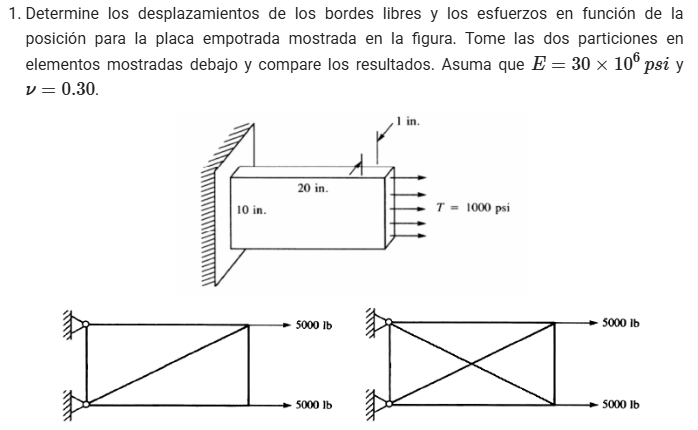

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
#   Datos iniciales de mi problema 

MN = np.array([[0, 0],
               [0, 10],
               [20, 10],
               [20, 0]])

MC = np.array([[0, 2, 1],
               [0, 3, 2]])

glxn = 2

E = 30e6

v = 0.3

t = 1

In [3]:
#   Defino una clase para ir guardando los datos que calcule de cada elemento

class ElementoFEM:
    def __init__(self, id, nodos, B, D, k_e, area, desp, Tension, TensionMax, TensionMin, angP):
        self.id = id                # Indice del elemento 
        self.nodos = nodos          # Nodos asociados al elemento (Lo saco de mi matriz de conectividad)
        self.B = B                  # matriz B del elemento
        self.D = D                  # Matriz D del elemento (puede ser diferente para cadda elemento)
        self.k_e = k_e              # Matriz elemental
        self.area = area            # Area del triangulo 
        self.desp = desp            # Desplazamientos para el calculo de la tension
        self.Tension = Tension      # Tension calculada para cada elemento
        self.TensionMax = TensionMax
        self.TensionMin = TensionMin
        self.angP =angP

In [4]:
def MatrizDeRigidez(MC, MN, E, v, glxn):

    n,m = MC.shape
    r,l = MN.shape

    KG = np.zeros((glxn*r,glxn*r))

    elementos = []
    desp = []
    Tension = []
    TensionMax = 0
    TensionMin = 0
    angP = 0             
        
    M = np.ones([3,3])

    D = E / (1 - v*v) * np.array([[1, v, 0],
                                  [v, 1, 0],
                                  [0, 0, 0.5*(1-v)]])

    B = np.zeros((3,6))

    for e in range(n):

        for i in range(m):

            M[i,1:] = MN[MC[e,i]]

            if i == 0:
                
                beta = MN[MC[e,1],1] - MN[MC[e,2],1]
                gamma = MN[MC[e,2],0] - MN[MC[e,1],0] 

                B[0,0] = beta
                B[2,1] = beta
                B[1,1] = gamma 
                B[2,0] = gamma

            if i == 1:
                beta = MN[MC[e,2],1] - MN[MC[e,0],1]
                gamma = MN[MC[e,0],0] - MN[MC[e,2],0]

                B[0,2] = beta
                B[2,3] = beta
                B[1,3] = gamma 
                B[2,2] = gamma

            if i == 2:
                beta = MN[MC[e,0],1] - MN[MC[e,1],1]
                gamma = MN[MC[e,1],0] - MN[MC[e,0],0]

                B[0,4] = beta
                B[2,5] = beta
                B[1,5] = gamma 
                B[2,4] = gamma

        #print(M)

        A  = np.linalg.det(M) / 2

        #print(A)

        B = 1/(2*A) * B

        k_e = t * A * np.transpose(B) @ D @ B

        #............................................................................................

        elemento = ElementoFEM(id=e,
                                nodos=MC[e,:].copy(), 
                                B=B.copy(), 
                                k_e=k_e.copy(), 
                                area=A, 
                                D=D.copy(), 
                                desp = desp.copy(), 
                                Tension = Tension.copy(),
                                TensionMax = TensionMax,
                                TensionMin = TensionMin,
                                angP = angP)
        
        elementos.append(elemento)

        #............................................................................................
            
        for i in range(m):

            ni = MC[e,i]

            rangoi = np.arange(i * glxn,( i + 1 ) * glxn)
                
            rangoni = np.arange(ni * glxn,( ni + 1 ) * glxn)

            for j in range(m):

                nj = MC[e,j]

                rangoj =  np.arange(j * glxn, (j + 1) * glxn)
                rangonj = np.arange(nj*glxn,(nj + 1) * glxn)

                KG[np.ix_(rangoni,rangonj)] += k_e[np.ix_(rangoi, rangoj)]

    #print(KG/(375000/0.91))

    return KG, elementos

In [ ]:
def ResolverSistemaMixto (A,b):

    #   Se define el vecctor de las esferzos (Fuerzas o Momentos) y los desplazamientos (Lineales o en angulo)

    n, m = np.shape(b)

    F = np.zeros([n,1])
    U = np.zeros([n,1])

    aux = b[:, 0] == 0  # Donde se conoce el valor del esfuerzo
    aux2 = b[:, 0] == 1  # Donde se conoce el valor del desplazamiento

    I = np.arange(n) # Se define un vector de indices


    f_indices = I[aux]   # Índices conocidos de esfuerzo
    u_indices = I[aux2]  # Índices conocidos de dezplazamiento

    #   Esto asigna los valores que ya conozco a los vectores de Esfuerzo y Desplazamiento que quiero de mi problema

    F[aux] = b[aux,1].reshape(-1, 1) 
    U[aux2] = b[aux2,1].reshape(-1, 1)

    #   Construyo la matriz reducida

    A_red_f = A[np.ix_(f_indices,f_indices)]

    #A_red_u = A[np.ix_(u_indices,u_indices)]

    f_aux = F[f_indices]
    #u_aux = U[u_indices]

    #   Resuelvo el sistema de ecuaciones reducido
    
    u_sol = np.linalg.inv(A_red_f) @ (f_aux - A[np.ix_(f_indices,u_indices)] @ U[u_indices])

    #print(u_sol)

    #   Asigno los valores calculados a mi vector de Desplazamientos con CC

    U[f_indices] = u_sol

    F = np.dot(A,U)     # Se multiplican las matries para encontrar el vector de Esfuerzos ... 

    return U, F

In [6]:
def calculoDeTension(MC,elementos,U):
    
    n,m = MC.shape

    Uaux = np.zeros((2*m,1))
    
    for e in range(n):

        for i in range(m):

            Uaux[2*i] = U[2*MC[e,i]]
            Uaux[2*i+1] = U[2*MC[e,i]+1]

        Tension = elementos[e].D @ elementos[e].B @ Uaux

        auxT1 = (Tension[0] + Tension[1])/2
        auxT2 = np.sqrt( ((Tension[0]-Tension[1])/2)**2 + Tension[2]**2 )

        tensionMax =  auxT1 + auxT2 
        tensionMin =  auxT1 - auxT2

        angP = np.arctan2((2 * Tension[2]) , (Tension[0] - Tension[1])) / 2


        elementos[e].desp = Uaux
        elementos[e].Tension = Tension
        elementos[e].TensionMax = tensionMax
        elementos[e].TensionMin = tensionMin
        elementos[e].angP = angP


    return elementos

In [7]:
#   Para el problema defino la matriz de condiciones de contorno. 

#   La primera columna me indica el tipo de dato que conozco
#       Si es 0 se conoce la fuerza
#       Si es 1 se conoce el desplazamiento

b = np.array([[ 1 , 0 ],        # Para el nodo 0 en x
              [ 1 , 0 ],        # Para el nodo 0 en y
              [ 1 , 0 ],        # Para el nodo 1 en x
              [ 1 , 0 ],        # Para el nodo 1 en y
              [ 0 , 5000 ],        # Para el nodo 2 en x
              [ 0 , 0 ],        # Para el nodo 2 en x
              [ 0 , 5000 ],        # Para el nodo 3 en x 
              [ 0 , 0 ]])       # Para el nodo 3 en y

In [8]:
KG,elementos = MatrizDeRigidez(MC, MN, E, v, glxn)

U,F = ResolverSistemaMixto (KG,b)

elementos = calculoDeTension(MC,elementos,U)

# print(np.round(elementos[0].D,1),'\n')

# print(elementos[0].D / (30e6/0.91))

# print(elementos[0].B / (1/200))

# print(elementos[0].k_e / (75000/0.91))

# print(elementos[0].Tension)
# print(elementos[1].Tension)



# print('Desplazamientos calculados [(1E-6) in]')
# print(np.round(U/1e-6,1),'\n')

# for e in range(MC.shape[0]):

#     print('Tensiones calculados para el elmento',e,'[psi]')
#     print(np.round(elementos[e].Tension,1),'\n')


In [9]:
MN1 = np.array([[0, 0],
                [10, 5],
                [20, 0],
                [20, 10],
                [0, 10]])

MC1 = np.array([[0, 2, 1],
                [1, 2, 3],
                [1, 3, 4],
                [1, 4, 0]])

#   Para el problema defino la matriz de condiciones de contorno. 

#   La primera columna me indica el tipo de dato que conozco
#       Si es 0 se conoce la fuerza
#       Si es 1 se conoce el desplazamiento

b1 = np.array([[ 1 , 0 ],        # Para el nodo 0 en x
              [ 1 , 0 ],        # Para el nodo 0 en y
              [ 0 , 0 ],        # Para el nodo 1 en x
              [ 0 , 0 ],        # Para el nodo 1 en y
              [ 0 , 5000 ],        # Para el nodo 2 en x
              [ 0 , 0 ],        # Para el nodo 2 en x
              [ 0 , 5000 ],        # Para el nodo 3 en x 
              [ 0 , 0 ],        # Para el nodo 3 en y
              [ 1 , 0 ],        # Para el nodo 4 en x
              [ 1 , 0 ]])       # Para el nodo 4 en y


In [10]:
KG1,elementos1 = MatrizDeRigidez(MC1, MN1, E, v, glxn)

U1,F1 = ResolverSistemaMixto (KG1,b1)

calculoDeTension(MC1,elementos1,U1)

# print('Desplazamientos calculados [(1E-6) in]')
# print(np.round(U1/1e-6,1),'\n')

# for e in range(MC1.shape[0]):

#     print('Tensiones calculados para el elmento',e,'[psi]')
#     print(np.round(elementos1[e].Tension,1),'\n')
#     # print('La tensión maxima para el elemento',e,' [psi]] ')
#     # print(np.round(elementos1[e].TensionMax,3),'\n')
#     # print('La tensión minima para el elemento',e,' [psi]] ')
#     # print(np.round(elementos1[e].TensionMin,3),'\n')

In [11]:
def graficar_armadura_con_deformacion(MN, MC, U, factor_amplificacion=1000):

    U_reshaped = U.reshape(-1, 2)
    
    MN_deformed = MN + U_reshaped * factor_amplificacion
    
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    graficar_armadura(ax1, MN, MC, 'Comparación Original vs Deformada', color='gray', linestyle='-')
    graficar_armadura(ax1, MN_deformed, MC, '', color='red')
    ax1.legend(['Original', 'Deformada'])
    
    plt.tight_layout()
    plt.show()

def graficar_armadura(ax, MN, MC, title, color='blue', linestyle='-'):
    """Función auxiliar para graficar armadura"""

    ax.plot(MN[:, 0], MN[:, 1], 'o', color=color, markersize=8)
    
    for elemento in MC:
        for i in range(len(elemento)-1):
            for j in range(i+1, len(elemento)):
                nodo_inicio = elemento[i]
                nodo_fin = elemento[j]
                x = [MN[nodo_inicio, 0], MN[nodo_fin, 0]]
                y = [MN[nodo_inicio, 1], MN[nodo_fin, 1]]
                ax.plot(x, y, linestyle=linestyle, color=color, linewidth=2)
    
    for i, (x, y) in enumerate(MN):
        ax.text(x, y, f'{i}', color='black', fontsize=10, ha='center', va='center')
    
    ax.set_xlabel('Coordenada X')
    ax.set_ylabel('Coordenada Y')
    ax.set_title(title)
    ax.grid(True)
    ax.axis('equal')

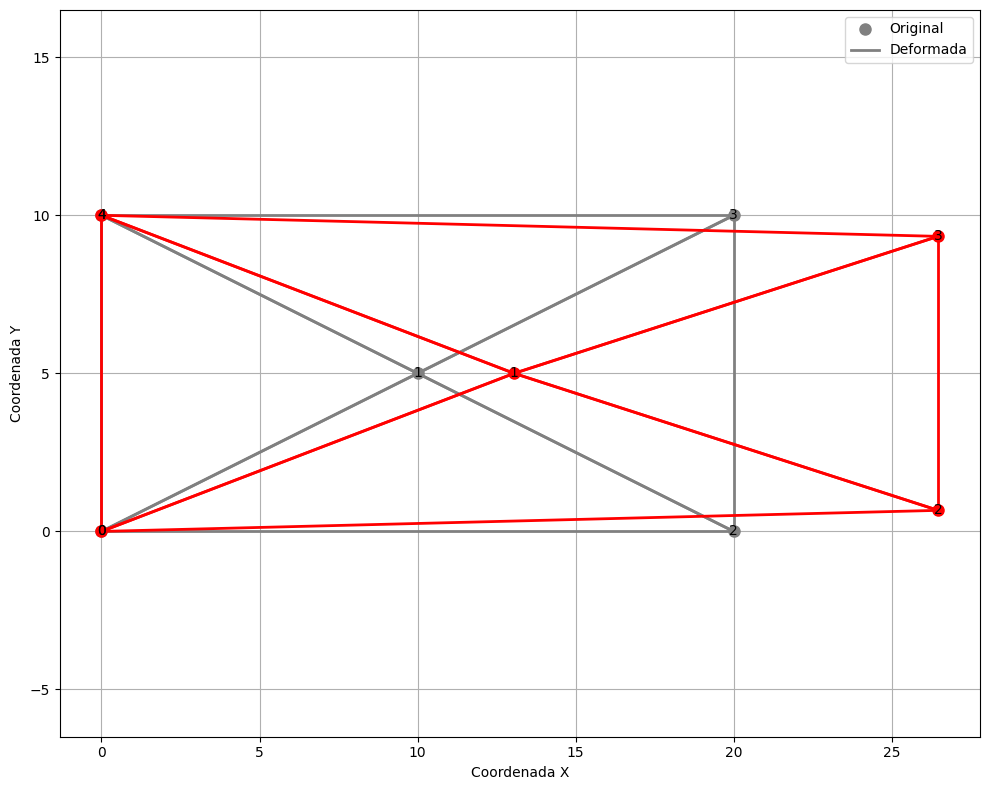

In [13]:
graficar_armadura_con_deformacion(MN1, MC1, U1,10000)